
# HW10 Assignment 2 - Spatial Data Analysis for Summer and Winter
This notebook in based on Assignment 1 and compares Summer and Winter

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import json
import requests
import urllib2
import statsmodels.api as sm
import shapely
import seaborn as sns

import pysal as ps


import matplotlib.pylab as pl
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File

In [2]:
from geopandas import GeoDataFrame
shape_path="ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

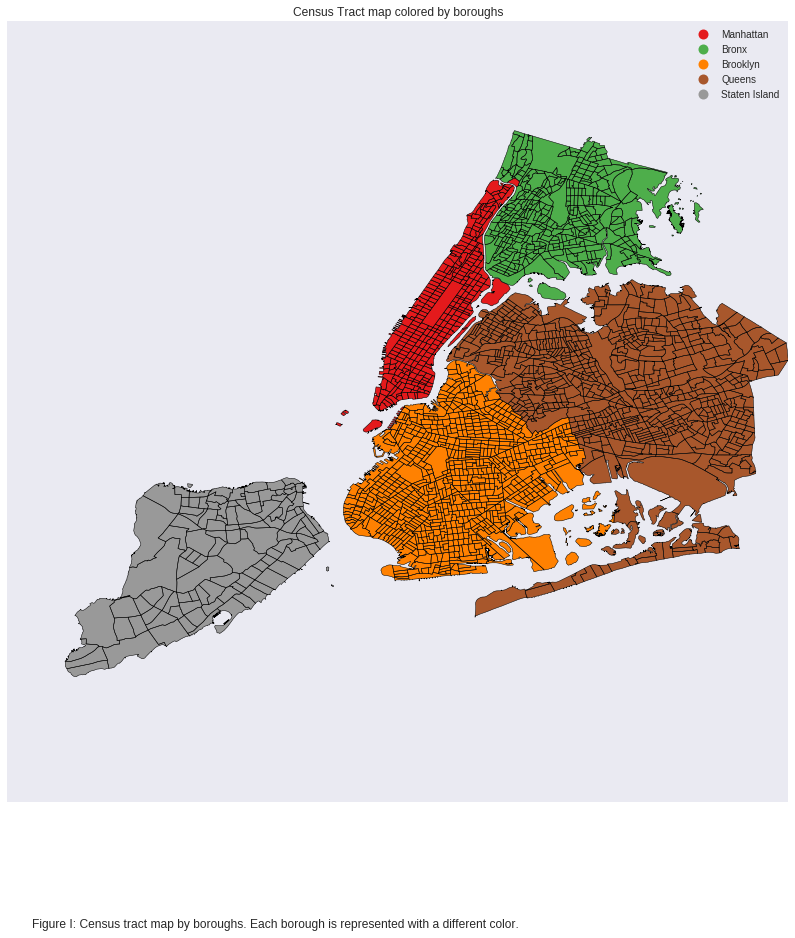

In [4]:
f, ax = pl.subplots(figsize=(14,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax, legend=True, )
legend = ax.get_legend()
legend.get_texts()[0].set_text('Manhattan')
legend.get_texts()[1].set_text('Bronx')
legend.get_texts()[2].set_text('Brooklyn')
legend.get_texts()[3].set_text('Queens')
legend.get_texts()[4].set_text('Staten Island')

pl.title("Census Tract map colored by boroughs")
pl.figtext(0.15,0,"Figure I: Census tract map by boroughs. Each borough is represented with a different color. ")

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data=DataFrame.from_csv('ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


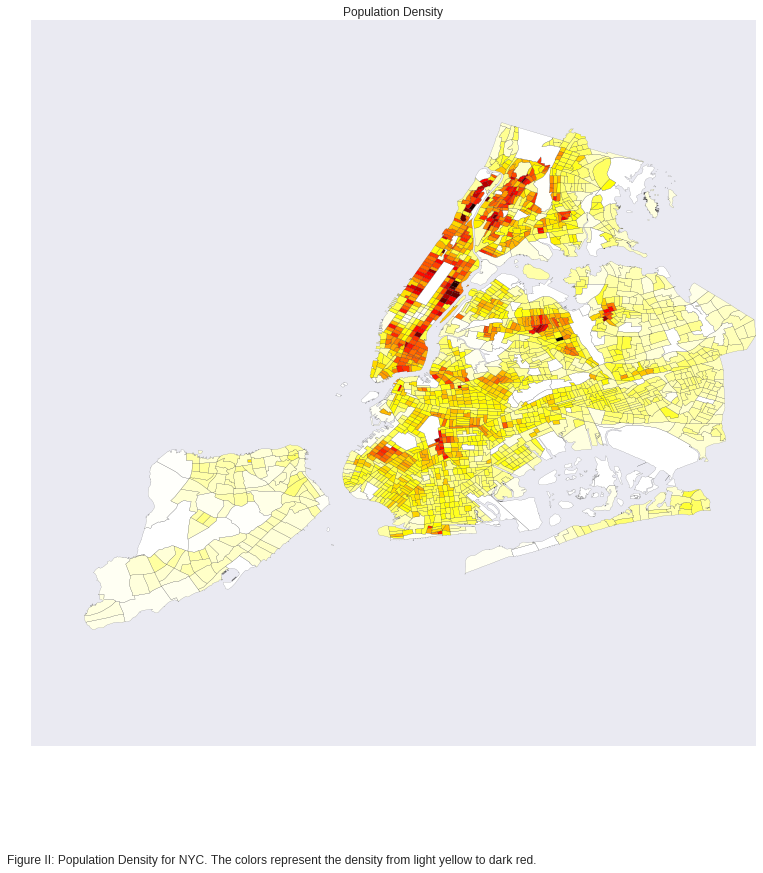

In [7]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")
pl.figtext(0.1,0,"Figure II: Population Density for NYC. The colors represent the density from light yellow to dark red.")

## Explore CitiBike data

### Load CitiBike data

In [8]:
df_bike_monthly=DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


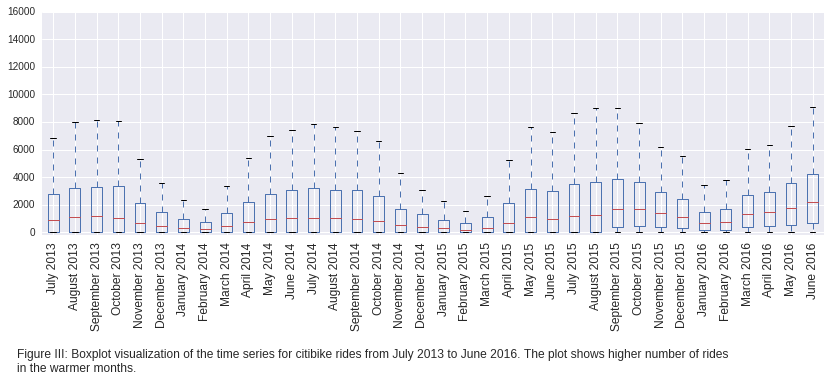

In [9]:
# Create a boxplot to visualize

pl.rcParams['font.size']=12
f, ax = pl.subplots(figsize=(14,4))

df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

pl.figtext(0.1,-.35,"Figure III: Boxplot visualization of the time series for citibike rides " 
          "from July 2013 to June 2016. The plot shows higher number of rides \n" 
           "in the warmer months.")

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


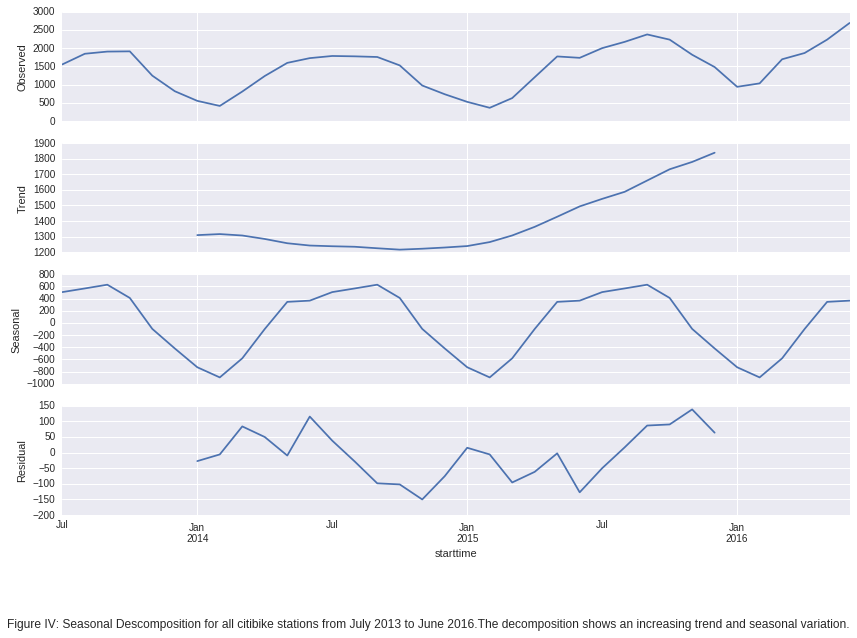

In [10]:
# Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

# Seasonal Decomposition using statsmodels api
# http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
pl.figtext(0.01,-.1,"Figure IV: Seasonal Descomposition for all citibike stations from July 2013 to June 2016."
           "The decomposition shows an increasing trend and seasonal variation.")

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [11]:
station_id=DataFrame.from_csv('Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [12]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [13]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [14]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

# Split the data into Winter and Summer

In [16]:
#Create dataframes for each season. Summer: June-September, Winter: December-March
df_summer = df_bike_monthly[(df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month >= 6)]
df_winter = df_bike_monthly[(df_bike_monthly.index.month <= 3) | (df_bike_monthly.index.month == 12)]

In [17]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['WinterAve']=df_winter.mean()
station_id['SummerAve']=df_summer.mean()

In [18]:
station_id

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve,SummerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1342.750000,3830.500000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000
1005,40.729387,-73.977724,"(-73.97772429, 40.72938685)",POINT (-73.97772429 40.72938685),1004400,1931.083333,4085.000000
1006,40.711464,-74.005524,"(-74.00552427, 40.71146364)",POINT (-74.00552427 40.71146364),1001501,785.500000,2314.500000
1007,40.726218,-73.983799,"(-73.98379855, 40.72621788)",POINT (-73.98379855 40.72621788),1003200,2148.500000,4622.750000
1008,40.760647,-73.984427,"(-73.98442659, 40.76064679)",POINT (-73.98442659 40.76064679),1012500,1237.250000,3745.583333
1009,40.716250,-74.009106,"(-74.0091059, 40.71625008)",POINT (-74.00910589999999 40.71625008),1003300,948.166667,2590.000000


### Add Winter and Summer Averages to the CT shapefile

In [21]:
### Add average monthly rides by seaon column from monthly citibike data and add it to the station id which has the geometry
temp = station_id[[ 'WinterAve', 'SummerAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_Aves = ct_shape.join(temp)
ct_shape_Aves.fillna(0, inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [22]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve,SummerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1342.750000,3830.500000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000


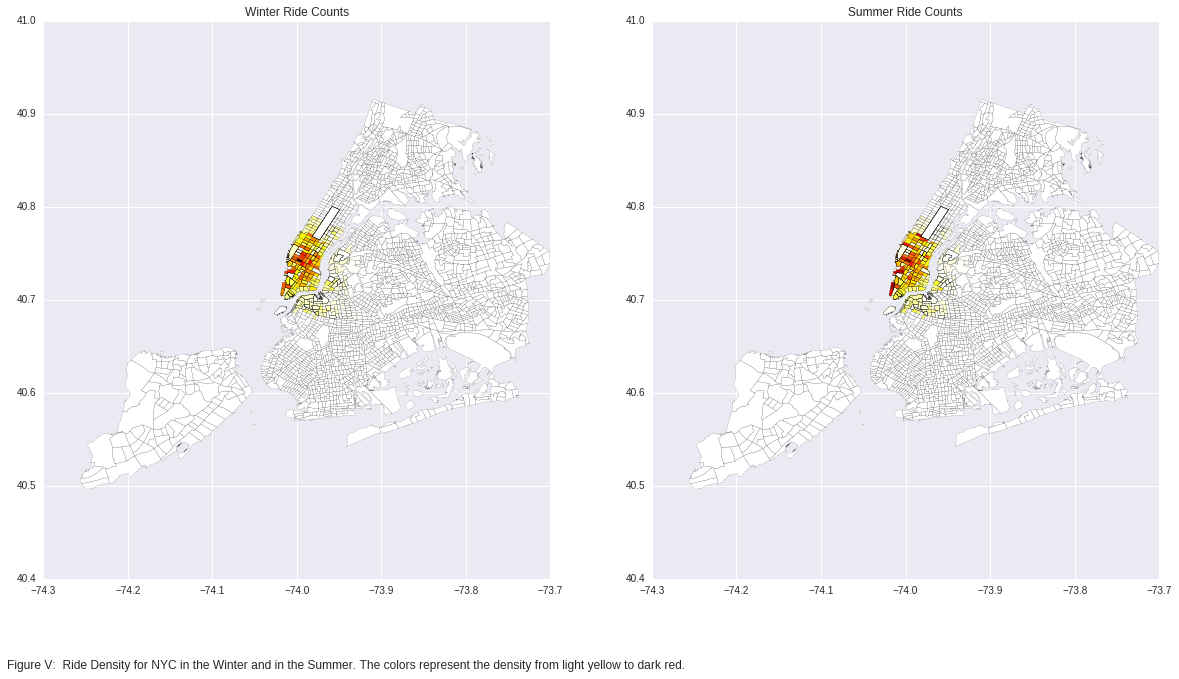

In [25]:
f, ax = pl.subplots(figsize=(20, 10))
ax1 = pl.subplot(121)
ct_shape_Aves.plot(column='WinterAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax1)
pl.title("Winter Ride Counts")
pl.figtext(0.1,0,"Figure V:  Ride Density for NYC in the Winter and in the Summer. "
           "The colors represent the density from light yellow to dark red.")

ax2 = pl.subplot(122)
ct_shape_Aves.plot(column='SummerAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax2)
pl.title("Summer Ride Counts")


### Removing the CTs that are out of zoom boundries

In [27]:
ct_shape_Aves_Zoom=(ct_shape_Aves[ct_shape_Aves
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [28]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs in Winter:", len(temp.WinterAve)
print "Number of zoomed CTs in Summer:", len(temp.SummerAve)

Total number of CTs: 2166
Number of zoomed CTs in Winter: 543
Number of zoomed CTs in Summer: 543


### Map the monthly rides 

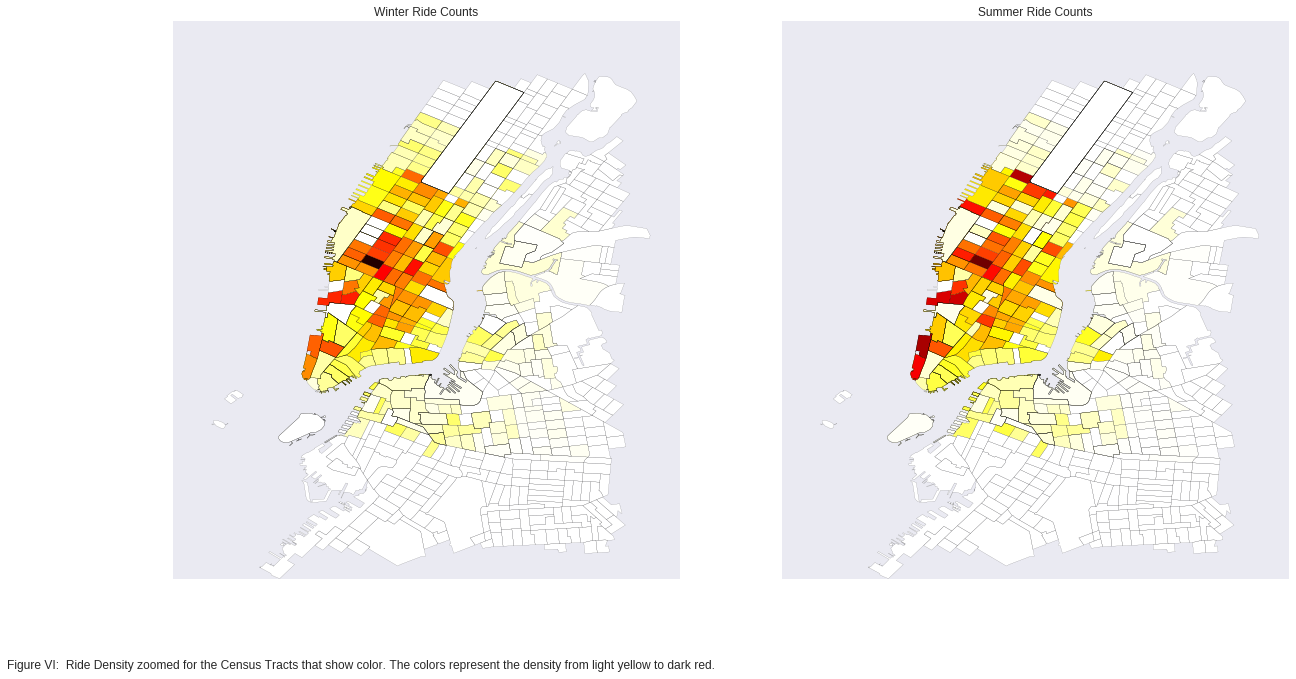

In [31]:
f, ax = pl.subplots(figsize=(20,10))

ax1 = pl.subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
pl.figtext(0.01,0,"Figure VI:  Ride Density zoomed for the Census Tracts that show color. The colors represent the density "
           "from light yellow to dark red. ")

ct_shape_Aves_Zoom.plot(column='WinterAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax1)
pl.title("Winter Ride Counts")

ax2 = pl.subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ct_shape_Aves_Zoom.plot(column='SummerAve', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax2)
pl.title("Summer Ride Counts")


### Export Shapefile CTs in the CitiBike Zone

In [34]:
path='ct_shape_Aves_Zoom.shp'
ct_shape_Aves_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [35]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [36]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [37]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [38]:
Wmatrix, ids = qW_CT.full()

In [39]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [40]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [42]:
WinterRide=ct_shape_Aves_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)
#give the lag of monthly rider ship, input the weighted

SummerRide=ct_shape_Aves_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)
#give the lag of monthly rider ship, input the weighted

#### Create Quantiles for maping

In [43]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print "Winter Ride Lag", WinterRideLagQ10
#by having a bin for less than 0, you take out the values that are less than 0

SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print "Summer Ride Lag", SummerRideLagQ10
#by having a bin for less than 0, you take out the values that are less than 0


Winter Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    4.595                 2
   4.595 < x[i] <=   75.189                78
  75.189 < x[i] <=  180.444                80
 180.444 < x[i] <=  287.743                79
 287.743 < x[i] <=  417.840                80
 417.840 < x[i] <=  937.426                79
 937.426 < x[i] <= 1267.157                80
1267.157 < x[i] <= 1539.785                79
1539.785 < x[i] <= 2491.899                80
Summer Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    7.333                 2
   7.333 < x[i] <=  125.969                78
 125.969 < x[i] <=  256.250                80
 256.250 < x[i] <=  629.283                81
 629.283 < x[i] <=  968.988                78
 968.988 < x[i] <= 2141.150                7

#### Map the monthly rides lag

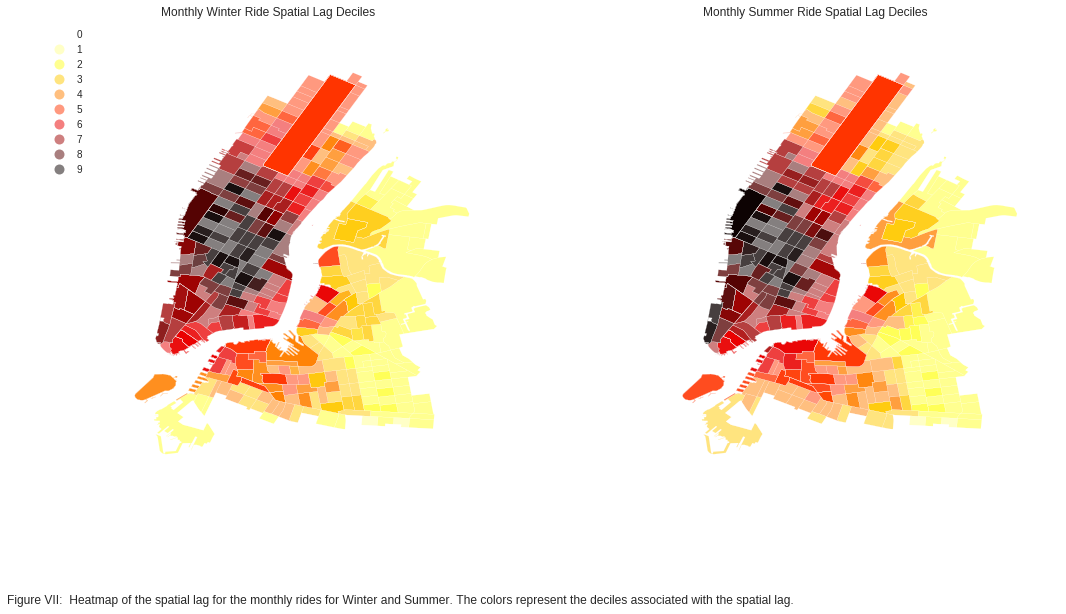

In [47]:
# Create a color map using the deciles
f, ax = pl.subplots(figsize=(18, 9))
ax1 = pl.subplot(121)
ct_shape_Aves_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
pl.title("Monthly Winter Ride Spatial Lag Deciles")

ax2 = pl.subplot(122)
ct_shape_Aves_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=False)
ax2.set_axis_off()
pl.title("Monthly Summer Ride Spatial Lag Deciles")
pl.figtext(0.1,0,"Figure VII:  Heatmap of the spatial lag for the monthly rides for Winter and Summer. "
           "The colors represent the deciles associated with the spatial lag. ")


## Global  Spatial Autocorrelation

In [48]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
print "Slope (Winter) = ", b, "Y-intercept: ", a 
#slope and intercept of a line (linear bc input = 1)

b2,a2 = np.polyfit(SummerRide, SummerRideLag, 1)
print "Slope (Summer) = ", b2, "Y-intercept: ", a2 

Slope (Winter) =  0.661894622507 Y-intercept:  194.318136773
Slope (Summer) =  0.643893143126 Y-intercept:  473.577589895


### Moran Scatterplot

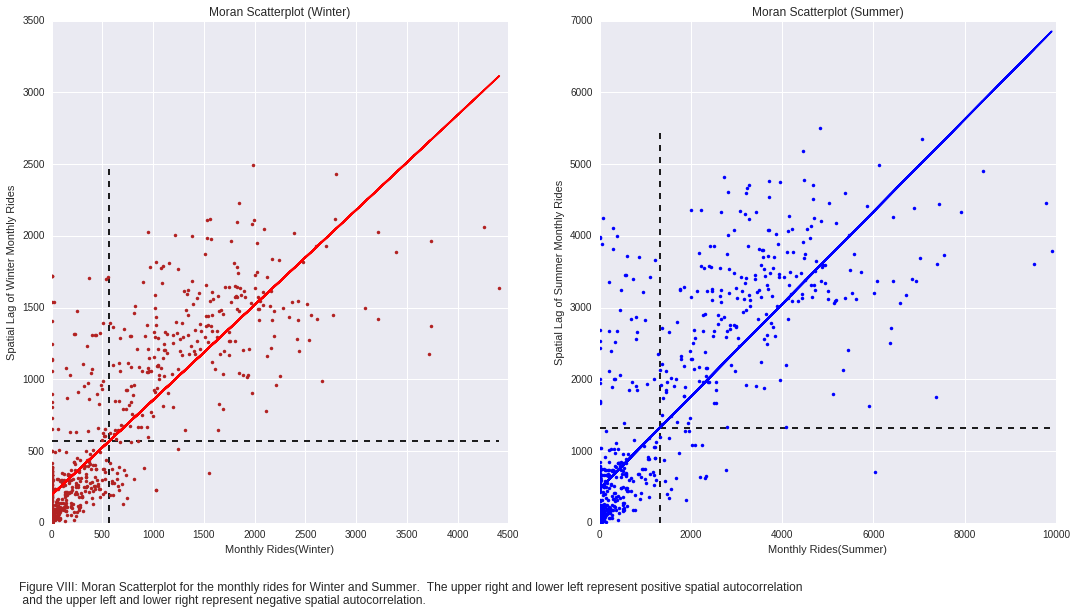

In [50]:
f, ax = pl.subplots(1, figsize=(18, 9))

ax1 = pl.subplot(121)
pl.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
pl.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(WinterRide, a + b*WinterRide, 'r')
pl.title('Moran Scatterplot (Winter)')
pl.ylabel('Spatial Lag of Winter Monthly Rides')
pl.xlabel('Monthly Rides(Winter)')

ax2 = pl.subplot(122)
pl.plot(SummerRide, SummerRideLag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
pl.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(SummerRide, a2 + b2*SummerRide, 'b')
pl.title('Moran Scatterplot (Summer)')
pl.ylabel('Spatial Lag of Summer Monthly Rides')
pl.xlabel('Monthly Rides(Summer)')

pl.figtext(0.1,0,"Figure VIII: Moran Scatterplot for the monthly rides for Winter and Summer. "
           " The upper right and lower left represent positive spatial autocorrelation \n and the"
           " upper left and lower right represent negative spatial autocorrelation. ")

### Moran's I

In [51]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [52]:
print "Winter", I_WinterRide.I, I_WinterRide.p_sim
print "Summer", I_SummerRide.I, I_SummerRide.p_sim


Winter 0.662044196711 0.001
Summer 0.644069499068 0.001


Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [53]:
print "Winter", I_WinterRide.sim[0:10]
print "Summer", I_SummerRide.sim[0:10]

Winter [-0.00120694  0.01687984  0.00785145 -0.01074163 -0.02402894 -0.02517974
  0.03641487 -0.01534595 -0.00777608  0.008501  ]
Summer [-0.01216451  0.0040073   0.01520327 -0.01046829  0.00384674 -0.00331651
  0.00096924  0.0158403  -0.00382314 -0.0121599 ]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [56]:
pl.rcParams['figure.figsize']=(14,3)

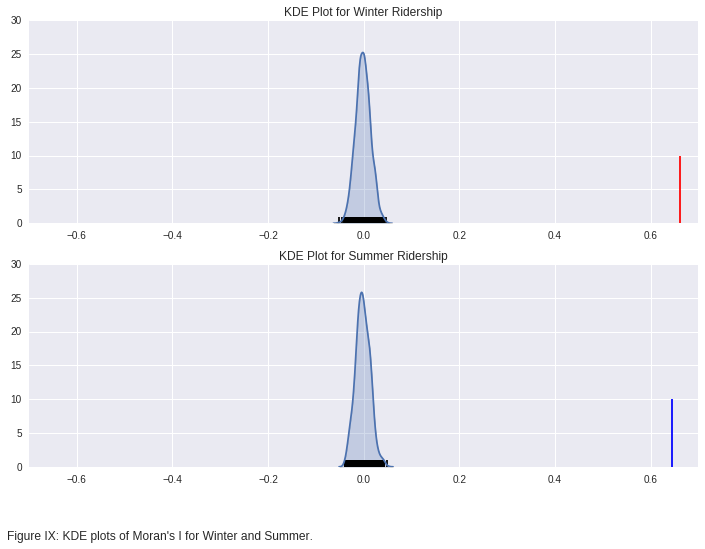

In [56]:
ax1 = pl.subplot(211)
sns.kdeplot(I_WinterRide.sim, shade=True)
pl.vlines(I_WinterRide.sim, 0, 1)
pl.vlines(I_WinterRide.I, 0, 10, 'r')
pl.xlim([-.70, .70])
ax1.set_title('KDE Plot for Winter Ridership')


ax2 = pl.subplot(212)
sns.kdeplot(I_SummerRide.sim, shade=True)
pl.vlines(I_SummerRide.sim, 0, 1)
pl.vlines(I_SummerRide.I, 0, 10, 'b')
pl.xlim([-.70, .70])
ax2.set_title('KDE Plot for Summer Ridership')

pl.figtext(0.1,0,"Figure IX: KDE plots of Moran's I for Winter and Summer. ")

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

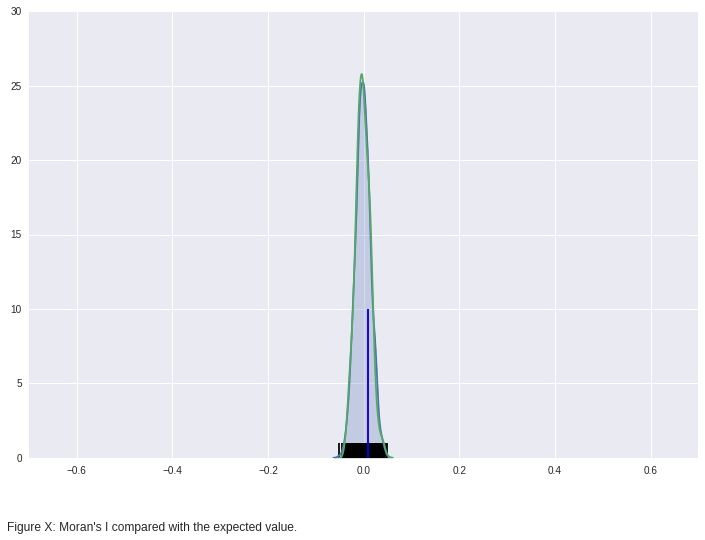

In [74]:
sns.kdeplot(I_WinterRide.sim, shade=True)
pl.vlines(I_WinterRide.sim, 0, 1)
pl.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
pl.xlim([-.70, .70])

sns.kdeplot(I_SummerRide.sim, shade=False)
pl.vlines(I_SummerRide.sim, 0, 1)
pl.vlines(I_SummerRide.EI+.01, 0, 10, 'b')
pl.xlim([-.70, .70])

pl.figtext(0.1,0,"Figure X: Moran's I compared with the expected value.")

## Local  Spatial Autocorrelation

In [58]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
print "Winter", LMo_WinterRide
print "Summer", LMo_SummerRide

Winter <pysal.esda.moran.Moran_Local object at 0x7f62724ec810>
Summer <pysal.esda.moran.Moran_Local object at 0x7f6271ff9090>


In [59]:
print "Winter", LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]
print "Summer", LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

Winter [-0.         -0.3153042  -0.00110645 -0.00100209 -0.06082761] [ 0.001  0.135  0.476  0.481  0.426]
Summer [-0.         -0.23689404  0.01179723  0.00235718  0.0247348 ] [ 0.001  0.195  0.356  0.342  0.385]


### LISA (Local Indicators of Spatial Autocorrelation)

In [60]:
Wsigs = WinterRide[LMo_WinterRide.p_sim <= .001]
WW_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
Winsigs = WinterRide[LMo_WinterRide.p_sim > .001]
WW_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

Ssigs = SummerRide[LMo_SummerRide.p_sim <= .001]
SW_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
Sinsigs = SummerRide[LMo_SummerRide.p_sim > .001]
SW_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

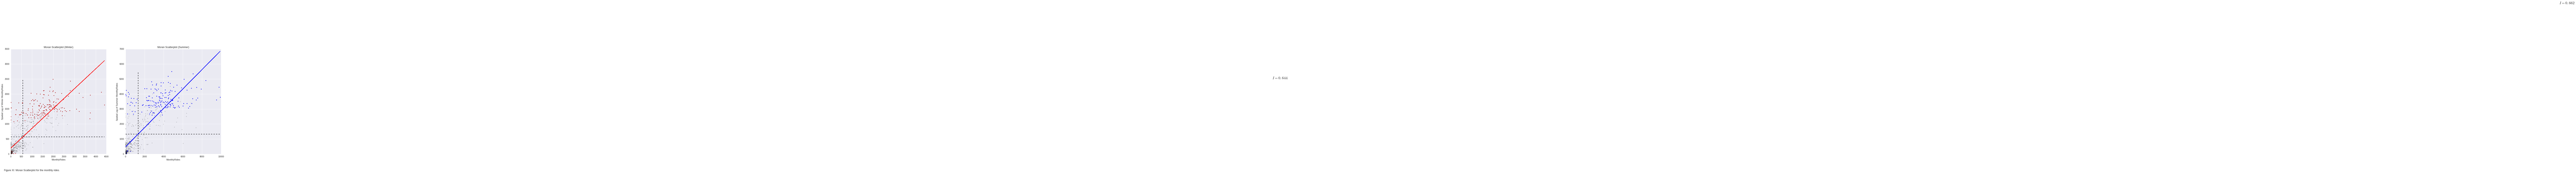

In [90]:
f, ax = pl.subplots(1, figsize=(18, 9))

ax1 = pl.subplot(121)
pl.plot(Wsigs, WW_sigs, '.', color='firebrick')
pl.plot(Winsigs, WW_insigs, '.k', alpha=.2)
pl.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
pl.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(WinterRide, a + b*WinterRide, 'r')
pl.title('Moran Scatterplot (Winter)')
pl.ylabel('Spatial Lag of Winter MonthlyRides')
pl.xlabel('MonthlyRides')

ax2 = pl.subplot(122)
pl.plot(Ssigs, SW_sigs, '.', color='blue')
pl.plot(Sinsigs, SW_insigs, '.k', alpha=.2)
pl.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
pl.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(SummerRide, a2 + b2*SummerRide, 'b')
pl.title('Moran Scatterplot (Summer)')
pl.ylabel('Spatial Lag of Summer MonthlyRides')
pl.xlabel('MonthlyRides')

pl.figtext(0.1,0,"Figure XI: Moran Scatterplot for the monthly rides.")

### I tried to make the plots bigger but it didn't change when I changed the numbers in figsize.

### Hot and Cold spots 

In [72]:
Wsig = LMo_WinterRide.p_sim < 0.01
#boundary of signficants
w_hotspots = LMo_WinterRide.q==1 * Wsig
w_coldspots = LMo_WinterRide.q==3 * Wsig
print "Number of Hotspots (Winter):", w_hotspots.sum()
print "Number of Coldspots (Winter):", w_coldspots.sum()

Ssig = LMo_SummerRide.p_sim < 0.01
#boundary of signficants
s_hotspots = LMo_SummerRide.q==1 * Ssig
s_coldspots = LMo_SummerRide.q==3 * Ssig
print "Number of Hotspots (Summer):", s_hotspots.sum()
print "Number of Coldspots (Summer):", s_coldspots.sum()

Number of Hotspots (Winter): 196
Number of Coldspots (Winter): 215
Number of Hotspots (Summer): 188
Number of Coldspots (Summer): 249


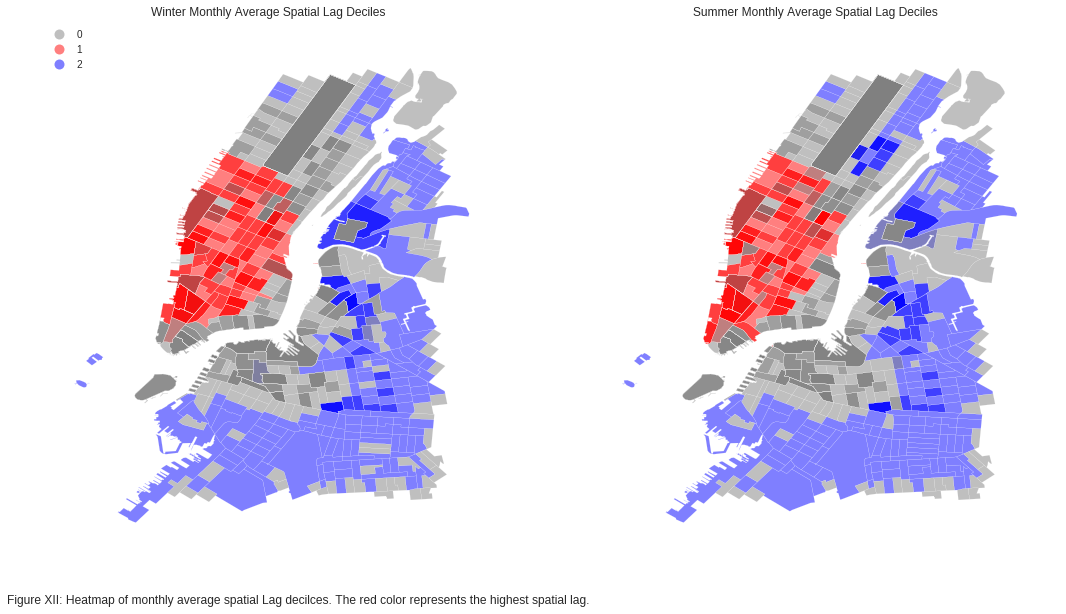

In [76]:
hcmap = colors.ListedColormap(['grey','red','blue'])
w_hotcold = w_hotspots*1 + w_coldspots*2
s_hotcold = s_hotspots*1 + s_coldspots*2
#if its true, it will be 1 * 1
#if its true, it will be 1 * 2
# if false, =0
# so either get 0, 1, 2

f, ax = pl.subplots(figsize=(18, 9))

ax1 = pl.subplot(121)
ct_shape_Aves_Zoom.assign(cl=w_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
pl.title("Winter Monthly Average Spatial Lag Deciles")

ax2 = pl.subplot(122)
ct_shape_Aves_Zoom.assign(cl=s_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=False)
ax2.set_axis_off()
pl.title("Summer Monthly Average Spatial Lag Deciles")

pl.figtext(0.1,0,"Figure XII: Heatmap of monthly average spatial Lag decilces."
          " The red color represents the highest spatial lag.")